In [4]:
#https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from numpy import split
from numpy import array
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = metrics.mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores


#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSeparator( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__(self):
        print('-->')
     
    #Return self nothing else to do here    
    def fit(self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None ):
        return [X[:, :, i] for i in range(43)]
    
df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 


# convert history into inputs and outputs
# flatten data
sequences_train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences_train, n_input, n_out)

sequences_test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test_x, test_y= split_sequences(sequences_test, n_input, n_out)

n_features = train_x.shape[2]
#--------------------------
# Define models using kersa and kerasregressor
#--------------------------


def MHMLP_model():
    n_input = 14
    n_features = 43
    n_out = 1
    visible= [Input(shape=(n_input,)) for i in range(n_features)]
    dense=[Dense(50, activation='relu', kernel_regularizer=l1(0.01))(visible[i]) for i in range(n_features)]
    merge = concatenate([dense[i] for i in range(n_features)])
    output = Dense(n_out)(merge)
    model = Model(inputs=[visible[i] for i in range(n_features)], outputs=output)
    model.compile(optimizer='Adam', loss='mse', metrics='mape')
    return model
model_MHMLP = KerasRegressor(build_fn=MHMLP_model, epochs=2000, batch_size=30, verbose=0)

# turn MHMLP into pipeline with separate input data
estimators = []
estimators.append(( 'separator' , FeatureSeparator()))
estimators.append(( 'mlp' , model_MHMLP))
model_MHMLPpl = Pipeline(estimators)

def CNN_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(n_input,
    n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu', kernel_regularizer=l1(0.01)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_CNN = KerasRegressor(build_fn=CNN_model, epochs=2000, batch_size=30, verbose=0)


def VLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(LSTM(64, activation='sigmoid', input_shape=(n_input, n_features)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_VLSTM = KerasRegressor(build_fn=VLSTM_model, epochs=400, batch_size=30, verbose=0)


ModelType='Stacked LSTM'
def SLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(LSTM(50, activation='sigmoid', return_sequences=True, input_shape=(n_input,n_features)))
    model.add(LSTM(25, activation='sigmoid'))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_SLSTM = KerasRegressor(build_fn=SLSTM_model, epochs=200, batch_size=30, verbose=0)


def BDLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(Bidirectional(LSTM(16, activation='sigmoid'), input_shape=(n_input, n_features)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_BDLSTM = KerasRegressor(build_fn=BDLSTM_model, epochs=400, batch_size=30, verbose=0)


def EDLSTM_model():
    n_input = 14
    n_features = 43
    n_out = 1
    model = Sequential()
    model.add(LSTM(100, activation='sigmoid', input_shape=(n_input, n_features)))
    model.add(RepeatVector(n_out))
    model.add(LSTM(100, activation='sigmoid', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mse', metrics='mape')
    return model
model_EDLSTM = KerasRegressor(build_fn=BDLSTM_model, epochs=200, batch_size=30, verbose=0)

# get a stacking ensemble of models
def get_stacking():
# define the base models
    level0 = list()
    #level0.append(('MHMLP', model_MHMLPpl))
    level0.append(('CNN', model_CNN))
    level0.append(('VLSTM', model_VLSTM))
    level0.append(('SLSTM', model_SLSTM))
    level0.append(('BDLSTM', model_BDLSTM))
    level0.append(('EDLSTM', model_EDLSTM))
# define meta learner model
    level1 = LinearRegression()
# define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model
 

# get a list of models to evaluate
def get_models():
    models = dict()
    models['Stacking'] = get_stacking()
    models['MHMLP'] = model_MHMLPpl
    models['CNN'] = model_CNN
    models['VLSTM'] = model_VLSTM
    models['SLSTM'] = model_SLSTM
    models['BDLSTM'] = model_BDLSTM
    models['EDLSTM'] = model_EDLSTM
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# define dataset
X, y = train_x, train_y
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

-->


ValueError: The estimator KerasRegressor should be a regressor.

In [ ]:
#np.save('results.npy', results, allow_pickle=True)
b = np.load('results.npy', allow_pickle=True)
print(b)

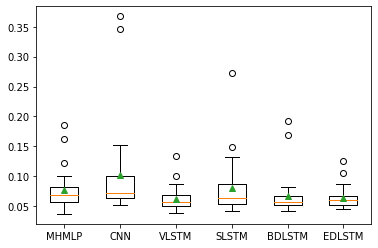

In [42]:
iresults=-b
iiresults=[]
for A in iresults:
    B=A[[(a<1) for a in A]]
    iiresults.append(B)
    
        
# plot model performance for comparison
plt.boxplot(iiresults, labels=names, showmeans=True)
plt.show()


In [ ]:
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot
 
 
# get a stacking ensemble of models
def get_stacking():
     # define the base models
     level0 = list()
     level0.append(('knn', KNeighborsRegressor()))
     level0.append(('cart', DecisionTreeRegressor()))
     level0.append(('svm', SVR()))
     # define meta learner model
     level1 = LinearRegression()
     # define the stacking ensemble
     model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
     return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	models['stacking'] = get_stacking()
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()